Guillaume FAURE et Garance LUCAS

# Exercice 1 - Construction de règles contre-factuelles

1. Ensembles de données

In [65]:
import random

import sklearn
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, export_text
import pandas as pd
import numpy as np
import random
import copy as cp

In [14]:
iris = load_iris()  
X,Y = iris.data, iris.target
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.2)

2. Arbre de décision

In [3]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
arbre = clf.tree_

Classe prédite:  [1 2 1 1 0 2 1 2 0 0 0 0 1 0 0 1 2 0 0 1 2 2 1 0 2 1 1 2 2 1]
Accuracy test:  1.0


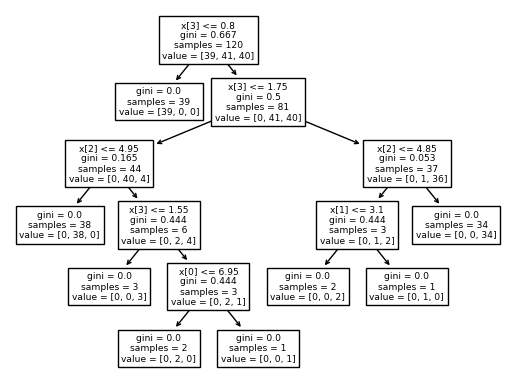

In [31]:
tree.plot_tree(clf)
y_pred = clf.predict(X_test)
print('Classe prédite: ', y_pred)
accuracy = clf.score(X_test, y_test)
print('Accuracy test: ', accuracy)

In [37]:
path = clf.decision_path(X_test)
print(path)

  (0, 0)	1
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (1, 0)	1
  (1, 2)	1
  (1, 10)	1
  (1, 14)	1
  (2, 0)	1
  (2, 2)	1
  (2, 3)	1
  (2, 4)	1
  (3, 0)	1
  (3, 2)	1
  (3, 3)	1
  (3, 4)	1
  (4, 0)	1
  (4, 1)	1
  (5, 0)	1
  (5, 2)	1
  (5, 10)	1
  (5, 14)	1
  (6, 0)	1
  (6, 2)	1
  (6, 3)	1
  :	:
  (24, 0)	1
  (24, 2)	1
  (24, 10)	1
  (24, 14)	1
  (25, 0)	1
  (25, 2)	1
  (25, 3)	1
  (25, 4)	1
  (26, 0)	1
  (26, 2)	1
  (26, 3)	1
  (26, 4)	1
  (27, 0)	1
  (27, 2)	1
  (27, 3)	1
  (27, 5)	1
  (27, 6)	1
  (28, 0)	1
  (28, 2)	1
  (28, 10)	1
  (28, 14)	1
  (29, 0)	1
  (29, 2)	1
  (29, 3)	1
  (29, 4)	1


In [22]:
print(arbre.node_count, arbre.feature)

15 [ 3 -2  3  2  3 -2 -2  3 -2 -2  2  0 -2 -2 -2]


3. Choix exemple

In [95]:
exemple_index = random.randint(0, len(X_test))
x = X_test[exemple_index]
print('Exemple: ', x)
x_reshape = np.array(x).reshape(1, -1)
y_pred = clf.predict(x_reshape)
print('Classe prédite: ', y_pred)
leaf = clf.apply(x_reshape)
print('Feuille: ', leaf)

path = clf.decision_path(x_reshape)
print("Chemin dans l'arbre: ")
print(path)

# Convertion du chemin en une liste d'indices de nœuds
node_indices = path.indices

feature_names = iris.feature_names

# Règles pour chaque nœud dans le chemin pour x
rules_x = []
for node_index in node_indices:
    node = clf.tree_.value[node_index]  # Valeur du nœud
    feature_index = clf.tree_.feature[node_index]  # Index de la caractéristique testée
    threshold = clf.tree_.threshold[node_index]  # Seuil utilisé pour le test
    
    rules_x.append(f"{feature_names[feature_index]} <= {threshold}")

    if node[0][0] > node[0][1]:
        class_label = "Classe 0"
    else:
        class_label = "Classe 1"

    print(f"Nœud {node_index}: Si la caractéristique {feature_index} <= {threshold}, alors {class_label}")
    
print("Règles pour x: ", rules_x)


Exemple:  [6.7 3.1 4.4 1.4]
Classe prédite:  [1]
Feuille:  [4]
Chemin dans l'arbre: 
  (0, 0)	1
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
Nœud 0: Si la caractéristique 3 <= 0.800000011920929, alors Classe 1
Nœud 2: Si la caractéristique 3 <= 1.75, alors Classe 1
Nœud 3: Si la caractéristique 2 <= 4.950000047683716, alors Classe 1
Nœud 4: Si la caractéristique -2 <= -2.0, alors Classe 1
Règles pour x:  ['petal width (cm) <= 0.800000011920929', 'petal width (cm) <= 1.75', 'petal length (cm) <= 4.950000047683716', 'petal length (cm) <= -2.0']


4. Règle contre-factuelles

In [96]:
from sklearn.tree import _tree

def find_paths(tree, node_id, current_path, x_class, leaf_paths):
    """
    Récursivement trouver tous les chemins d'un nœud donné vers les feuilles
    qui ont une classe différente de x_class.
    """
    # Si c'est une feuille
    if tree.children_left[node_id] == _tree.TREE_LEAF:
        # Si la classe de la feuille est différente de x_class
        if tree.value[node_id].argmax() != x_class:
            # Ajouter le chemin à la liste
            leaf_paths.append((current_path, tree.value[node_id].argmax()))
        return

    # Si c'est un nœud interne, appeler récursivement sur les enfants
    if tree.children_left[node_id] != _tree.TREE_LEAF:
        find_paths(tree, tree.children_left[node_id], current_path + [(node_id, 'left')], x_class, leaf_paths)
    if tree.children_right[node_id] != _tree.TREE_LEAF:
        find_paths(tree, tree.children_right[node_id], current_path + [(node_id, 'right')], x_class, leaf_paths)

def get_leaf_paths_for_different_class(clf, x, feature_names):
    """
    Obtenir tous les chemins de l'arbre clf qui mènent à des feuilles
    dont la classe prédite est différente de celle prédite pour l'exemple x.
    """
    # Prédire la classe pour l'exemple x
    x_class = clf.predict([x])[0]

    # Initialiser la liste pour stocker les chemins
    leaf_paths = []
    find_paths(clf.tree_, 0, [], x_class, leaf_paths)

    # Traduire les chemins en règles
    paths_with_rules = []
    for path, class_idx in leaf_paths:
        rules = []
        for node_id, direction in path:
            if direction == 'left':
                threshold = clf.tree_.threshold[node_id]
                feature = feature_names[clf.tree_.feature[node_id]]
                rules.append(f"{feature} <= {threshold}")
            else:
                threshold = clf.tree_.threshold[node_id]
                feature = feature_names[clf.tree_.feature[node_id]]
                rules.append(f"{feature} > {threshold}")
        paths_with_rules.append((rules, clf.classes_[class_idx]))

    return paths_with_rules

# Appliquer la fonction à notre exemple x
paths = get_leaf_paths_for_different_class(clf, x, feature_names)

for rules, class_name in paths:
    print(f"Rules: {rules} => Class: {iris.target_names[class_name]}")

Rules: ['petal width (cm) <= 0.800000011920929'] => Class: setosa
Rules: ['petal width (cm) > 0.800000011920929', 'petal width (cm) <= 1.75', 'petal length (cm) > 4.950000047683716', 'petal width (cm) <= 1.550000011920929'] => Class: virginica
Rules: ['petal width (cm) > 0.800000011920929', 'petal width (cm) <= 1.75', 'petal length (cm) > 4.950000047683716', 'petal width (cm) > 1.550000011920929', 'sepal length (cm) > 6.949999809265137'] => Class: virginica
Rules: ['petal width (cm) > 0.800000011920929', 'petal width (cm) > 1.75', 'petal length (cm) <= 4.8500001430511475', 'sepal width (cm) <= 3.100000023841858'] => Class: virginica
Rules: ['petal width (cm) > 0.800000011920929', 'petal width (cm) > 1.75', 'petal length (cm) > 4.8500001430511475'] => Class: virginica


In [97]:
count_chemin = []

for path,_ in paths:
    count = 0
    for rules in rules_x:
        if rules in path:
            count += 1
    count_chemin.append(count)
    
print(count_chemin)

[1, 1, 1, 0, 0]


5. Explication pour la classification d'un exemple

In [102]:
explication = np.argmax(count_chemin)
path_explication = paths[explication]


differences = [(i, a, b) for i, (a, b) in enumerate(zip(path_explication, rules_x)) if a != b]

# Afficher les différences
for _, val1, val2 in differences:
    print(f"valeurs différentes: l'explication a {val1}, l'exemple a {val2}")

valeurs différentes: l'explication a ['petal width (cm) <= 0.800000011920929'], l'exemple a petal width (cm) <= 0.800000011920929
valeurs différentes: l'explication a 0, l'exemple a petal width (cm) <= 1.75


6.  